# Exploration of the human Tau protein modification Subgraph

The goal of this notebook is to extract a subgraph from `hbp_knowledge` that containts the Tau protein, its post-translational modifications, and the upstream controllers that induce the corresponding phosphorylations.

The BEL graph used in this notebook is retreived using the `hbp_knowledge` package that wraps the curated BEL content deposited at https://github.com/pharmacome/knowledge. Most of the BEL files in this repository correspond to exactly one article. However, some that are topic-oriented contain information from several articles.

In [1]:
import time
import sys
from collections import defaultdict
from operator import attrgetter

import matplotlib.pyplot as plt

import bio2bel_hgnc
import bio2bel_drugbank
import hbp_knowledge
import pandas as pd
import pybel
import pybel.struct
import pybel_jupyter
import pybel_tools
from pybel.dsl import *
from pybel.manager.citation_utils import get_pubmed_citation_response
from pybel_tools.filters import get_variants_to_controllers
from pybel_jupyter import to_jupyter

In [2]:
%matplotlib inline

## Environment

In [3]:
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:39) 
[Clang 10.0.0 (clang-1000.11.45.5)]


In [4]:
print(time.asctime())

Tue Apr 16 14:50:58 2019


In [5]:
print(f"""HBP-Knowledge    v{hbp_knowledge.VERSION}
PyBEL            v{pybel.get_version()}
PyBEL-Tools      v{pybel_tools.get_version()}
PyBEL-Jupyter    v{pybel_jupyter.get_version()}
Bio2BEL HGNC     v{bio2bel_hgnc.get_version()}
Bio2BEL DrugBank v{bio2bel_drugbank.get_version()}""")

HBP-Knowledge    v0.0.4-dev
PyBEL            v0.13.2-dev
PyBEL-Tools      v0.7.3-dev
PyBEL-Jupyter    v0.2.2-dev
Bio2BEL HGNC     v0.2.4-dev
Bio2BEL DrugBank v0.1.2-dev


# Data

## Acquiring and Normalizing the Graph

Retrieve the graph from `hbp_knowledge`.

In [6]:
graph = hbp_knowledge.repository.get_graph()

Remove pathologies from the graph - they aren't the focus of this notebook.

In [7]:
pybel.struct.remove_pathologies(graph)

Normalize the proteins in the network using [Bio2BEL HGNC](https://github.com/bio2bel/hgnc).

In [8]:
hgnc_manager = bio2bel_hgnc.Manager()

if not hgnc_manager.is_populated():
    raise RuntimeError('Populate Bio2BEL HGNC first!')

hgnc_manager.normalize_genes(graph)

Normalize the chemicals in the network using [Bio2BEL DrugBank](https://github.com/bio2bel/drugbank).

In [9]:
drugbank_manager = bio2bel_drugbank.Manager()

if not drugbank_manager.is_populated():
    raise RuntimeError('Populate Bio2BEL DrugBank first!')
    
drugbank_manager.normalize_drugs(graph)

Summarize the normalized graph

In [10]:
graph.summarize()

Human Brain Pharmacome Knowledge v0.0.4-dev
Number of Nodes: 4885
Number of Edges: 14497
Number of Citations: 328
Number of Authors: 1837
Network Density: 6.08E-04
Number of Components: 126
Number of Warnings: 28


In [11]:
pybel.struct.summary.count_namespaces(graph)

Counter({'CHEBI': 382,
         'GO': 543,
         'MESH': 413,
         'HBP': 445,
         'HP': 9,
         'MGI': 237,
         'PUBCHEM': 100,
         'FPLX': 127,
         'HGNCGENEFAMILY': 32,
         'CTO': 1,
         'UNIPROT': 12,
         'TAXONOMY': 4,
         'RGD': 77,
         'INTERPRO': 64,
         'GFAM': 8,
         'MESHC': 4,
         'DRUGBANK': 1,
         'DNSNP': 2,
         'NCBIGENE': 2,
         'DBSNP': 13,
         'ECCODE': 18,
         'PFAM': 2,
         'CL': 3,
         'SCOMP': 1,
         'SFAM': 2,
         'BRCO': 1,
         'MIRBASE': 3,
         'HGNC': 1,
         'hgnc': 1486})

## Selecting the Subgraph

Identify any `pybel.dsl.Protein` that is a variant of `pybel.dsl.Protein('HGNC', 'MAPT')` that contains either a phosphorylation or hyper-phosphorylation.

In [12]:
mapt_protein = Protein('hgnc', 'MAPT')
mapt_protein

<BEL p(hgnc:MAPT)>

In [13]:
modifications = set() # {'Ph', 'hyperphosphorylation'} 

In [14]:
modified_mapts = get_variants_to_controllers(graph, mapt_protein, modifications)

n_variants = len(modified_mapts)
n_controllers = len(set(
    controller
    for controllers in modified_mapts.values()
    for controller in controllers
))

print(f'there are {n_variants} variants of Tau with {n_controllers} unique upstream controllers')

there are 74 variants of Tau with 199 unique upstream controllers


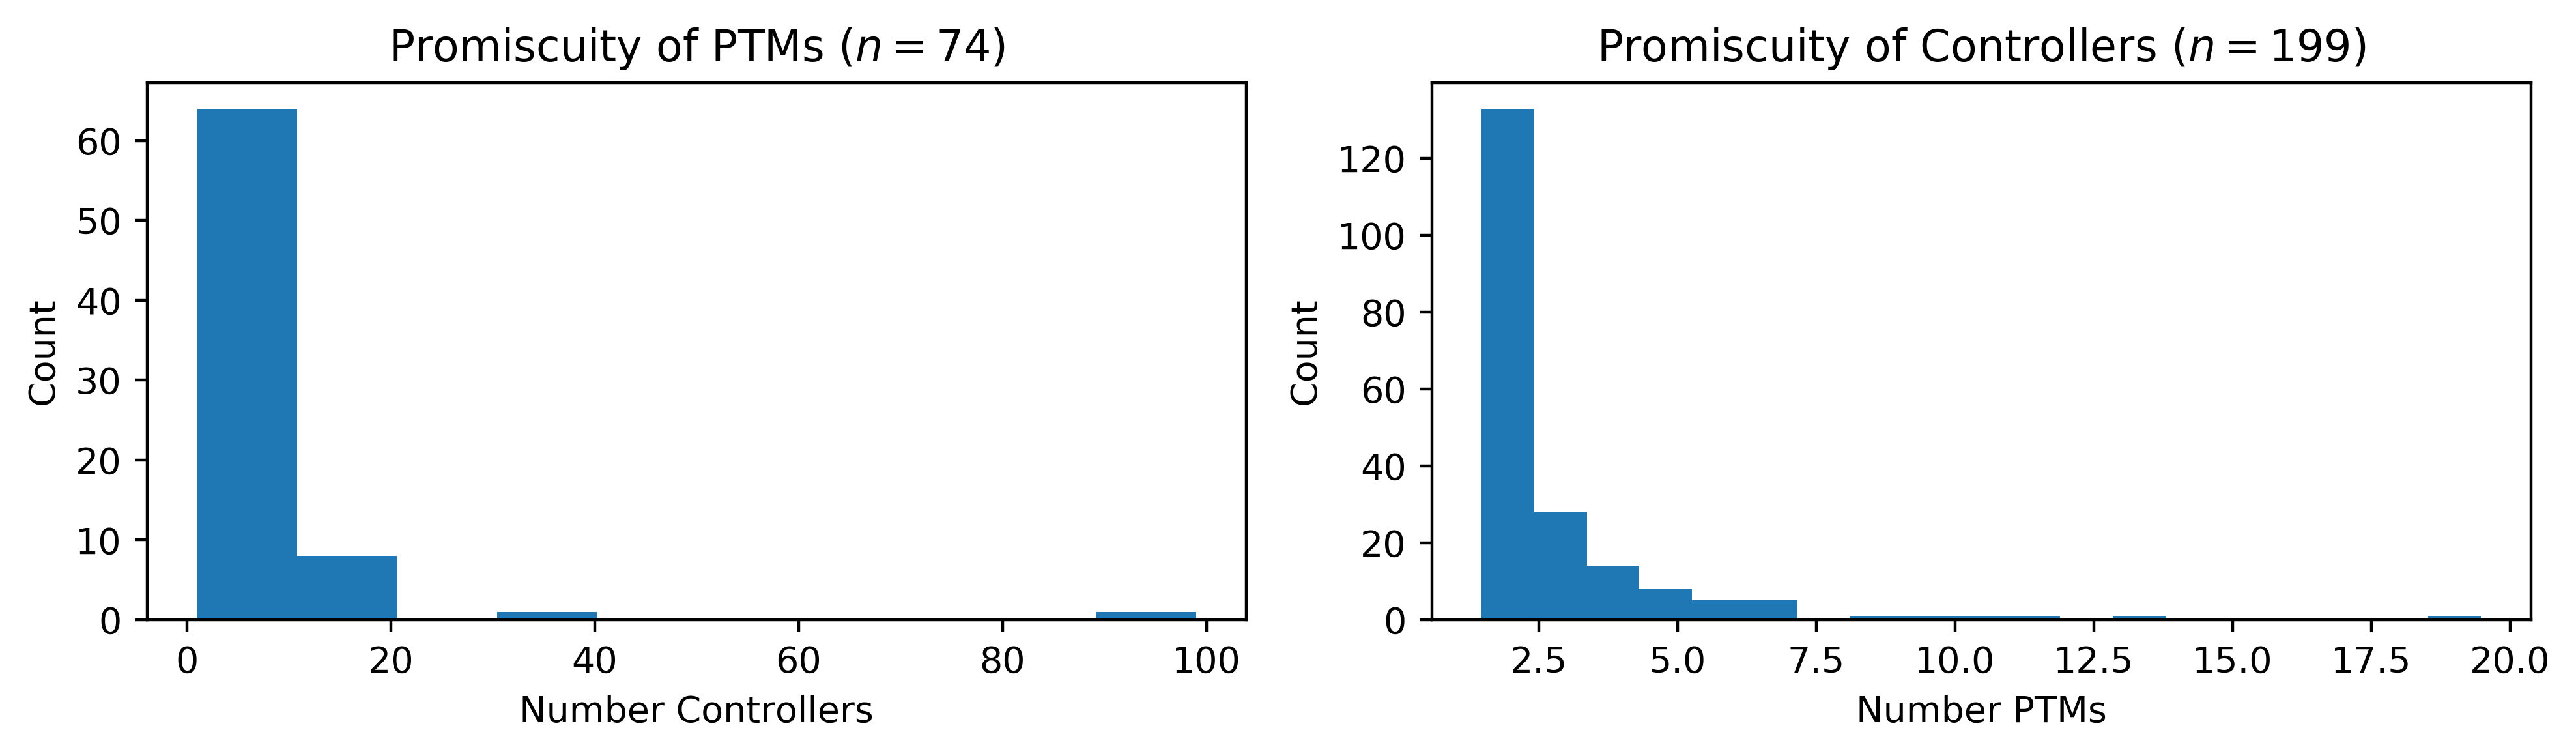

In [15]:
controller_to_modification = defaultdict(set)
for variant, controllers in modified_mapts.items():
    for controller in controllers:
        controller_to_modification[controller].add(variant)
        

fig, (rax, lax) = plt.subplots(1, 2, figsize=(10, 3), dpi=400)

h = [len(v) for v in controller_to_modification.values()]
lax.hist(h, bins=max(h), align='right')
lax.set_title(f'Promiscuity of Controllers ($n={n_controllers}$)')
lax.set_xlabel('Number PTMs')
lax.set_ylabel('Count')

h = [len(v) for v in modified_mapts.values()]
rax.hist(h)
rax.set_title(f'Promiscuity of PTMs ($n={n_variants}$)')
rax.set_xlabel('Number Controllers')
rax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Get the subgraph of containing all of the neighbors (via any relationships) of any of the phosphorlyated variants identified in the previous cell. Additionally, throw away any `pybel.dsl.Pathology` nodes, since they appear as hubs and provide little information.

In [16]:
ptm_graph = pybel.struct.get_subgraph_by_neighborhood(graph, modified_mapts)
ptm_graph.summarize()

None vNone
Number of Nodes: 382
Number of Edges: 1076
Number of Citations: 136
Number of Authors: 788
Network Density: 7.39E-03
Number of Components: 1
Number of Warnings: 0


Display the subgraph using `pybel_jupyter`.

In [17]:
to_jupyter(ptm_graph)

<IPython.core.display.Javascript object>

Extract all PubMed identifiers from the graph, and write them to a file in this directory called `tau-phosphorylation-pmids.txt`.

In [18]:
pmids = {
    data['citation']['reference']
    for _, _, data in ptm_graph.edges(data=True)
    if 'citation' in data
}

with open('tau-ptm-pmids.txt', 'w') as file:
    for pmid in sorted(pmids):
        print(f'pmid:{pmid}', file=file)

print(f'there are {len(pmids)} PubMed references')

there are 136 PubMed references


## Enrich Proteins in the Subgraph with their Corresponding Drugs

Enrich the targets contained within the subgraph using [Bio2BEL DrugBank](https://github.com/bio2bel/drugbank).

In [19]:
drugbank_manager.enrich_targets(ptm_graph)
ptm_graph.summarize()

None vNone
Number of Nodes: 964
Number of Edges: 2725
Number of Citations: 527
Number of Authors: 788
Network Density: 2.94E-03
Number of Components: 1
Number of Warnings: 0


Identify all proteins in the subgraph that have a chemical that regulates them. These relationships were likely added by the enrichment with DrugBank.

In [20]:
target_to_chemical = defaultdict(set)
chemical_to_target = defaultdict(set)
for chemical, target, key, data in ptm_graph.edges(keys=True, data=True):
    if (
        isinstance(chemical, Abundance) 
        and data['relation'] == 'regulates' 
        and not target.variants
    ):
        target_to_chemical[target].add(chemical)
        chemical_to_target[chemical].add(target)

        
n_drugged_targets = len(target_to_chemical)
n_chemicals = len(set(
    chemical
    for chemicals in target_to_chemical.values()
    for chemical in chemicals
))
print(f'There are {n_drugged_targets} proteins that have been previously drugged by {n_chemicals} unique chemicals')

There are 49 proteins that have been previously drugged by 580 unique chemicals


Output an OBO-style list of the proteins in the subgraph that have been drugged to the file `targeted-tau-ptm-controllers.txt`. Additionally, print them here for posterity.

In [21]:
with open('targeted-tau-ptm-controllers.txt', 'w') as file:
    for t in sorted(target_to_chemical, key=attrgetter('name')):
        t_modifications = [
            '/'.join(sorted(map(str, [v for v in x.variants if isinstance(v, ProteinModification)])))
            for x in controller_to_modification[t]
        ]
        s = f'hgnc:{t.identifier}', f'hgnc.symbol:{t.name}', ";".join(sorted(t_modifications))
        print(*s, sep='\t')
        print(*s, sep='\t', file=file)

hgnc:76	hgnc.symbol:ABL1	pmod(Ph, Tyr);pmod(Ph, Tyr, 363);pmod(Ph, Tyr, 394)
hgnc:77	hgnc.symbol:ABL2	pmod(Ph, Tyr, 394)
hgnc:361	hgnc.symbol:AK1	pmod(Ph)
hgnc:937	hgnc.symbol:BAG1	
hgnc:1460	hgnc.symbol:CAMK2A	pmod(Ph);pmod(Ph, Ser, 262)
hgnc:1461	hgnc.symbol:CAMK2B	pmod(Ph)
hgnc:1722	hgnc.symbol:CDK1	pmod(Ph);pmod(Ph, Thr, 231)
hgnc:1771	hgnc.symbol:CDK2	pmod(Ph);pmod(Ph, Ser, 199);pmod(Ph, Ser, 202);pmod(Ph, Ser, 235);pmod(Ph, Ser, 396);pmod(Ph, Ser, 404);pmod(Ph, Thr, 212);pmod(Ph, Thr, 217)
hgnc:1774	hgnc.symbol:CDK5	pmod(HBP:hyperphosphorylation);pmod(Ph);pmod(Ph, Ser, 199);pmod(Ph, Ser, 202);pmod(Ph, Ser, 235);pmod(Ph, Ser, 396);pmod(Ph, Ser, 404);pmod(Ph, Ser, 422);pmod(Ph, Thr, 181);pmod(Ph, Thr, 205);pmod(Ph, Thr, 231)
hgnc:16627	hgnc.symbol:CHEK2	pmod(Ph, Ser, 262)
hgnc:1950	hgnc.symbol:CHRM1	pmod(HBP:hyperphosphorylation);pmod(Ph)
hgnc:1958	hgnc.symbol:CHRNA4	
hgnc:1960	hgnc.symbol:CHRNA7	
hgnc:2348	hgnc.symbol:CREBBP	pmod(Ac, Lys)
hgnc:2451	hgnc.symbol:CSNK1A1	pmod(Ph);pmo

Get the PubMed identifiers of just the relationships attached to targets that are known to be drugged. This is provides a filter for which articles should be checked for assay information later - keeping in mind that all of the relationships for these proteins are either from the DrugBank enrichment, or were added to the subgraph because they regulate the phosphorylation of the Tau protein. This means that all of their other relations' articles should contain interesting assay information on how that phosphorylation was measured.

In [22]:
drugged_pmids = {
    d["citation"]["reference"]
    for u, v, d in ptm_graph.edges(data=True)
    if (
        'citation' in d 
        and (u in target_to_chemical or v in target_to_chemical) 
        and d['evidence'] != 'From DrugBank'
    )
}

print(f'there are {len(drugged_pmids)} PubMed references for relationships containing a drugged target')

there are 64 PubMed references for relationships containing a drugged target


Get extra information about the articles, including their PubMed Central (PMC) identifiers, when available.

In [23]:
pmid_to_targets = defaultdict(set)
for u, v, d in ptm_graph.edges(data=True):
    citation = d.get('citation')
    if citation is None or d['evidence'] == 'From DrugBank':
        continue
    reference = citation['reference']
    if u in target_to_chemical:
        pmid_to_targets[reference].add(u)
    if v in target_to_chemical:
        pmid_to_targets[reference].add(v)

In [24]:
pubmed_response = get_pubmed_citation_response(pmid_to_targets)

pmid_pmc_map = {}

for pmid in pubmed_response['result']['uids']:
    for article_id in pubmed_response['result'][pmid]['articleids']:
        if 'pmc' == article_id['idtype']:
            pmid_pmc_map[pmid] = article_id['value']

Output an exploded table connecting the PubMed identifiers (PMIDs), PMC identifiers, and the proteins. Some articles are not in PMC, and only have PMIDs.

In [25]:
df = pd.DataFrame(
    data=[
        (
            target.name,
            target.identifier,
            pmid,
            pmid_pmc_map.get(pmid),
        )
    for pmid, targets in pmid_to_targets.items()
    for target in targets
    ], 
    columns=['hgnc.symbol', 'hgnc', 'pmid', 'pmc']
).sort_values(['hgnc.symbol', 'pmid'])

# Output
df.to_csv('tau-ptm-article-targets.tsv', sep='\t', index=False)

# Show in notebook
df

,hgnc.symbol,hgnc,pmid,pmc
114,ABL1,76,17493042,None
113,ABL1,76,23687953,PMC3750680
8,ABL1,76,26631930,None
62,ABL1,76,29191965,None
19,ABL2,77,26631930,None
118,AK1,361,22419736,None
103,BAG1,937,17954934,None
10,CAMK2A,1460,26631930,None
30,CAMK2B,1461,12428809,None
4,CDK1,1722,10391244,None
